# 1. Importing everything that is necessary

In [29]:
import numpy as np
from file_crop_bash import file_crop
import time
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from libfmp.b.b_plot import plot_signal, plot_chromagram
from libfmp.c3.c3s2_dtw_plot import plot_matrix_with_points

from synctoolbox.dtw.core import compute_warping_path
from synctoolbox.dtw.cost import cosine_distance

%matplotlib inline

Fs = 22050
figsize = (9,3)

# 2. Preparing and loading the audio file we want to align 

- We will use the 2003_Gielen_Mahler_IX-1.mp3 as our reference audio and anotation 
- We will use the 1965_Berstein_Mahler_IX-1.mp3 to do the alignement
- Finally we will focus on a part starting at 12min30s with a duration of 2 mins

### a. We crop the two audio and annotation files : 

In [6]:
file_crop(t_start = 12*60+30, length=120, audio_path ="/home/osboxes/automatic_alignement/data_sync_experiment/1965_Bernstein_Mahler_IX-1.mp3", data_path = "/home/osboxes/automatic_alignement/data_sync_experiment/1965_Bernstein_Mahler_IX-1_bpb_147-329.txt" )
file_crop(t_start = 12*60+30, length=120, audio_path ="/home/osboxes/automatic_alignement/data_sync_experiment/2003_Gielen_Mahler_IX-1.mp3", data_path = "/home/osboxes/automatic_alignement/data_sync_experiment/2003_Gielen_Mahler_IX-1_bpb_CU_final_updated_22-11-2021.txt" )

Done in : 1.2468349933624268s + 0.0670156478881836s =1.3138506412506104


(<Figure size 648x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Version 1'}, xlabel='Time (seconds)', ylabel='Amplitude'>,
 [<matplotlib.lines.Line2D at 0x7f001a2a7ac0>])

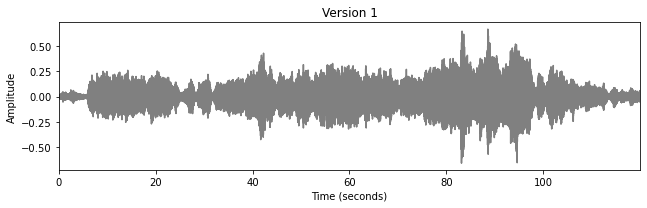

In [12]:
audio_ref, _ = librosa.load('/home/osboxes/automatic_alignement/data_sync_experiment/2003_Gielen_Mahler_IX-1_t750s_l120s.wav', Fs)

plot_signal(audio_ref, Fs=Fs, ylabel='Amplitude', title='Version 1', figsize=figsize)

(<Figure size 648x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Version 1'}, xlabel='Time (seconds)', ylabel='Amplitude'>,
 [<matplotlib.lines.Line2D at 0x7f0014699bb0>])

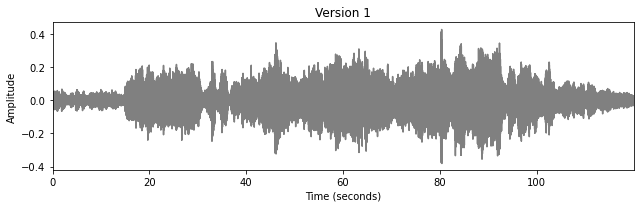

In [13]:
audio_align, _ = librosa.load('/home/osboxes/automatic_alignement/data_sync_experiment/1965_Bernstein_Mahler_IX-1_t750s_l120s.wav', Fs)

plot_signal(audio_align, Fs=Fs, ylabel='Amplitude', title='Version 1', figsize=figsize)

# 3. Processing both audio to have chromogram in the same key

A simple comb-based algorithm is used to detect tuning deviations in the two audio recordings

In [16]:
from synctoolbox.feature.utils import estimate_tuning

In [19]:
tuning_offset_ref = estimate_tuning(audio_ref, Fs)
tuning_offset_align = estimate_tuning(audio_align, Fs)
print('Estimated tuning deviation for recording 1: %d cents, for recording 2: %d cents' % (tuning_offset_ref, tuning_offset_align))

Estimated tuning deviation for recording 1: 16 cents, for recording 2: 14 cents


### a. Chroma and DLNCO

The Alignement method (MrMsDTW) uses two features to perform the alignement : the Chroma sequences on a coarse level and the Decaying locally adaptive normalized chroma onset (DLNCO).
Therefore we need to compute both of them.

But we need to be careful because to get the DLNCO we need a dictionary of "peaks", so we have to get those peaks first by using the function : **audio_to_pitch_onset_features()**

In [20]:
from synctoolbox.feature.pitch_onset import audio_to_pitch_onset_features
from synctoolbox.feature.dlnco import pitch_onset_features_to_DLNCO
from synctoolbox.feature.pitch import audio_to_pitch_features
from synctoolbox.feature.chroma import pitch_to_chroma, quantize_chroma

feature_rate = 50 #Number of features per seconds in the output representation

Generating filterbank...
Downsampling signal...
Processing midi pitches 21 to 108
.........30.........40.........50.........60.........70.........80.........90.........100........


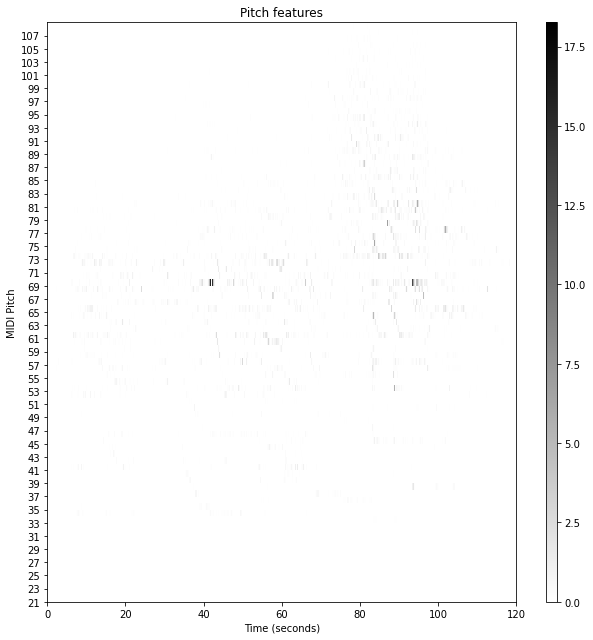

Generating filterbank...
Downsampling signal...
Processing midi pitches 21 to 108
.........30.........40.........50.........60.........70.........80.........90.........100........


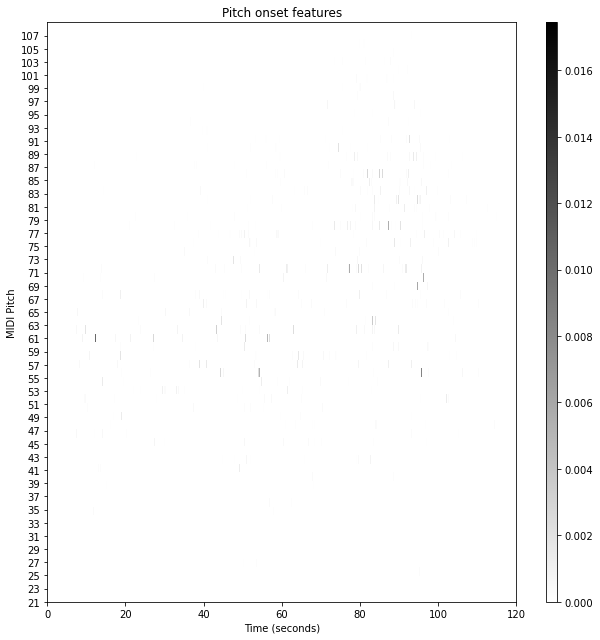

Generating filterbank...
Downsampling signal...
Processing midi pitches 21 to 108
.........30.........40.........50.........60.........70.........80.........90.........100........


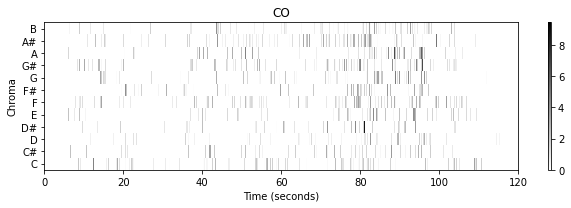

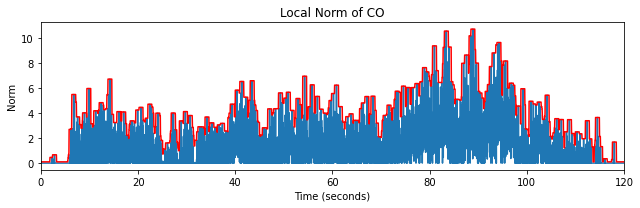

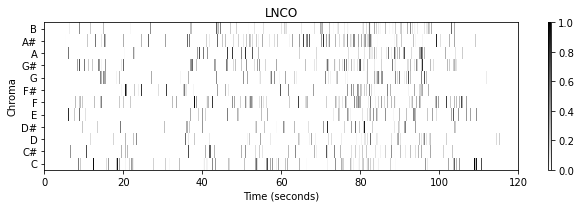

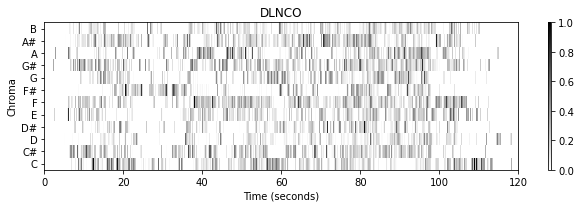

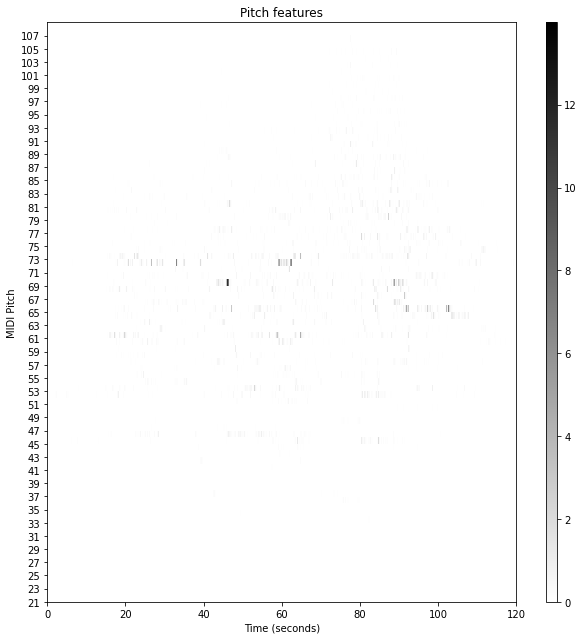

Generating filterbank...
Downsampling signal...
Processing midi pitches 21 to 108
.........30.........40.........50.........60.........70.........80.........90.........100........


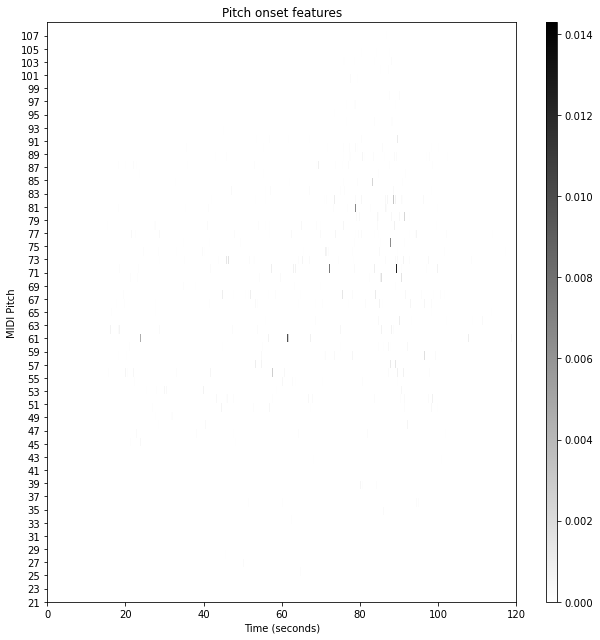

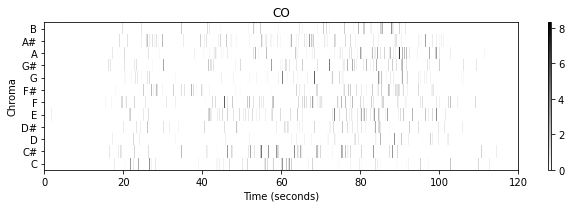

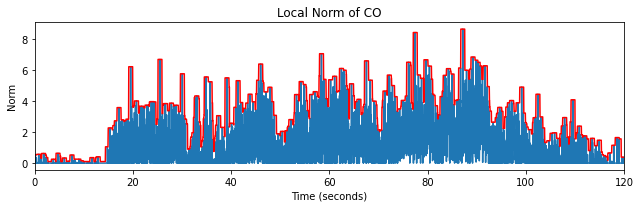

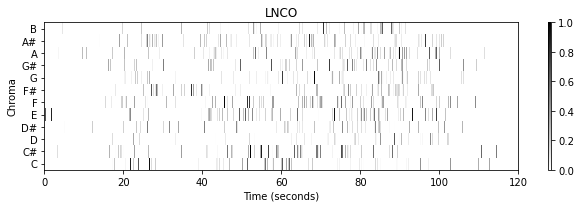

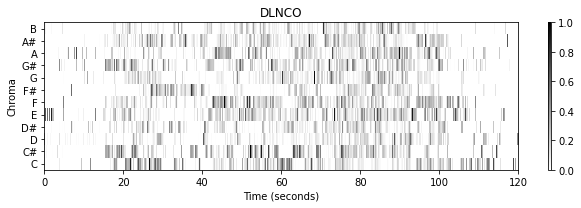

In [21]:
def get_features_from_audio(audio, tuning_offset, visualize=True):
    f_pitch = audio_to_pitch_features(f_audio=audio, Fs=Fs, tuning_offset=tuning_offset, feature_rate=feature_rate, verbose=visualize)
    f_chroma = pitch_to_chroma(f_pitch=f_pitch)
    f_chroma_quantized = quantize_chroma(f_chroma=f_chroma)

    f_pitch_onset = audio_to_pitch_onset_features(f_audio=audio, Fs=Fs, tuning_offset=tuning_offset, verbose=visualize)
    f_DLNCO = pitch_onset_features_to_DLNCO(f_peaks=f_pitch_onset, feature_rate=feature_rate, feature_sequence_length=f_chroma_quantized.shape[1], visualize=visualize)
    return f_chroma_quantized, f_DLNCO

f_chroma_quantized_ref, f_DLNCO_ref = get_features_from_audio(audio_ref, tuning_offset_ref)
f_chroma_quantized_align, f_DLNCO_align = get_features_from_audio(audio_align, tuning_offset_align)

We can see that the pitch onset features of the align file are less pronounced than the one's for the reference file. Maybe we should normalize the audio loudness between the files.

### b. Shifting the Chroma vectors in order to have them in key

Now that we have both chroma, we will shift the one from the align file to match the key of the reference

In [25]:
from synctoolbox.feature.chroma import quantized_chroma_to_CENS
from synctoolbox.dtw.utils import compute_optimal_chroma_shift

In [26]:
f_cens_1hz_ref = quantized_chroma_to_CENS(f_chroma_quantized_ref, 201, 50, feature_rate)[0]
f_cens_1hz_align = quantized_chroma_to_CENS(f_chroma_quantized_align, 201, 50, feature_rate)[0]
opt_chroma_shift = compute_optimal_chroma_shift(f_cens_1hz_ref, f_cens_1hz_align)
print('Pitch shift between recording ref and recording align, determined by DTW:', opt_chroma_shift, 'bins')

Pitch shift between recording ref and recording align, determined by DTW: 0 bins


In our case it means that both recordings are in keys.

# 4. Performing the alignement with MrMsDTW

In [30]:
from synctoolbox.dtw.mrmsdtw import sync_via_mrmsdtw

step_weights = np.array([1.5, 1.5, 2.0]) #DTW step weights
threshold_rec = 10 ** 6 #Defines the maximum area that is spanned by the rectangle of two consecutive elements in the alignment 

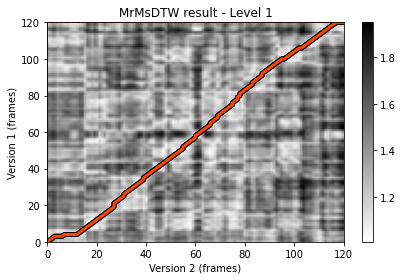

Level 0 computation time: 3.17 seconds


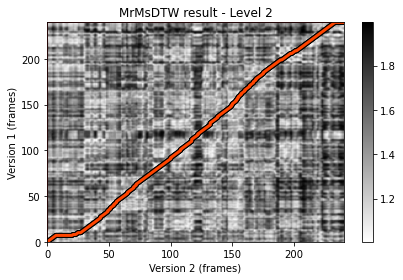

Level 1 computation time: 0.81 seconds


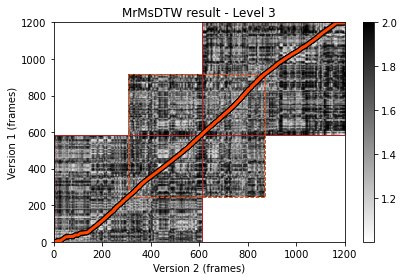

Level 2 computation time: 0.32 seconds


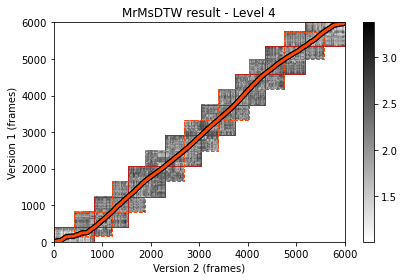

Level 3 computation time: 7.12 seconds
Computation time of MrMsDTW: 11.42 seconds


In [31]:
wp = sync_via_mrmsdtw(f_chroma1=f_chroma_quantized_ref, f_onset1=f_DLNCO_ref, f_chroma2=f_chroma_quantized_align, f_onset2=f_DLNCO_align, input_feature_rate=feature_rate, step_weights=step_weights, threshold_rec=threshold_rec, verbose=True)

In [32]:
from synctoolbox.dtw.utils import make_path_strictly_monotonic

In [33]:
wp = make_path_strictly_monotonic(wp)

# 5. Transfering the measure annotations

In [102]:
import pandas as pd
import scipy
from synctoolbox.dtw.utils import evaluate_synchronized_positions
header_name = ["time","beat"]

In [103]:
beat_annotations_ref = pd.read_csv(filepath_or_buffer='/home/osboxes/automatic_alignement/data_sync_experiment/2003_Gielen_Mahler_IX-1_bpb_CU_final_updated_22-11-2021_t750s_l120s.csv',names = header_name)
beat_annotations_align = pd.read_csv(filepath_or_buffer='/home/osboxes/automatic_alignement/data_sync_experiment/1965_Bernstein_Mahler_IX-1_bpb_147-329_t750s_l120s.csv', names = header_name)
beat_annotations_align = beat_annotations_align.loc[beat_annotations_align['beat'].isin(beat_annotations_ref['beat'])].reset_index(drop = True) #We make sure that we compare only the same beats 


beat_positions_ref_transferred_to_align = scipy.interpolate.interp1d(wp[0] / feature_rate, wp[1] / feature_rate, kind='linear')(beat_annotations_ref["time"])
mean_absolute_error, accuracy_at_tolerances = evaluate_synchronized_positions(beat_annotations_align["time"] * 1000, beat_positions_ref_transferred_to_align * 1000)

Measure transfer from recording 1 to 2 yielded:

Mean absolute error (MAE): 323.75ms (standard deviation: 1295.12ms)

Accuracy of transferred positions at different tolerances:
			Accuracy
################################
Tolerance: 10 ms 	10.08 %
Tolerance: 20 ms 	19.38 %
Tolerance: 30 ms 	24.03 %
Tolerance: 40 ms 	32.56 %
Tolerance: 50 ms 	41.86 %
Tolerance: 60 ms 	49.61 %
Tolerance: 70 ms 	55.04 %
Tolerance: 80 ms 	63.57 %
Tolerance: 90 ms 	68.99 %
Tolerance: 100 ms 	72.87 %
Tolerance: 150 ms 	89.15 %
Tolerance: 250 ms 	93.02 %


Exporting the transfered beat annotations

In [106]:
beat_position_transfered_ref_to_align = pd.DataFrame(data = beat_positions_ref_transferred_to_align, columns = ["time"])
beat_position_transfered_ref_to_align["beat"] = beat_annotations_ref["beat"]
beat_position_transfered_ref_to_align.to_csv('/home/osboxes/automatic_alignement/data_sync_experiment/1965_Bernstein_Mahler_IX-1_bpb_147-329_t750s_l120s_alignement_from_2003_Gielen.csv', header = False, index = False)